V2. Использовался кроп изображения для SAM. Использовалась выгрузка модели SAM на CPU, пока работает модель CLIP

Слабая семантика

In [2]:
# === Шаг 1: Импорт всех библиотек ===
# (Импорты остаются теми же)
import torch, cv2, numpy as np, matplotlib.pyplot as plt, os
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

# === Шаг 2: Настройка окружения и загрузка моделей ===
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Используемое устройство: {device}")

# --- Загрузка Segment Anything Model (SAM) ---
print("Загрузка модели SAM...")
sam_checkpoint = "/app/MODELS/sam_vit_h_4b8939.pth"
model_type = "vit_h"
# Просто загружаем модель, НЕ создавая генератор
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
print("SAM готов.")

# --- Загрузка CLIP ---
print("Загрузка модели CLIP...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
print("CLIP готов.")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Используемое устройство: cuda
Загрузка модели SAM...
SAM готов.
Загрузка модели CLIP...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


CLIP готов.


Создан генератор масок с поддержкой кропов для больших изображений.

--- Обработка изображения: 1_normals.jpg ---
Изображение загружено.
Временно выгружаю CLIP с GPU для освобождения VRAM...
Запускаю сегментацию (это может занять время)...
Сегментация завершена. Найдено 16 масок.
Возвращаю CLIP на GPU для быстрой классификации...

Запускаю классификацию масок с помощью CLIP...
  Маска 1/16: небо (уверенность: 0.38)
  Маска 2/16: небо (уверенность: 0.47)
  Маска 3/16: земля (уверенность: 0.28)
  Маска 4/16: небо (уверенность: 0.40)
  Маска 5/16: небо (уверенность: 0.29)
  Маска 6/16: небо (уверенность: 0.31)
  Маска 7/16: деревья (уверенность: 0.21)
  Маска 8/16: растения (уверенность: 0.20)
  Маска 9/16: металлическая конструкция (уверенность: 0.42)
  Маска 10/16: земля (уверенность: 0.30)
  Маска 11/16: небо (уверенность: 0.23)
  Маска 12/16: другой объект (уверенность: 0.20)
  Маска 13/16: небо (уверенность: 0.29)
  Маска 14/16: металлическая конструкция (уверенность: 0.23)
  Маска 1

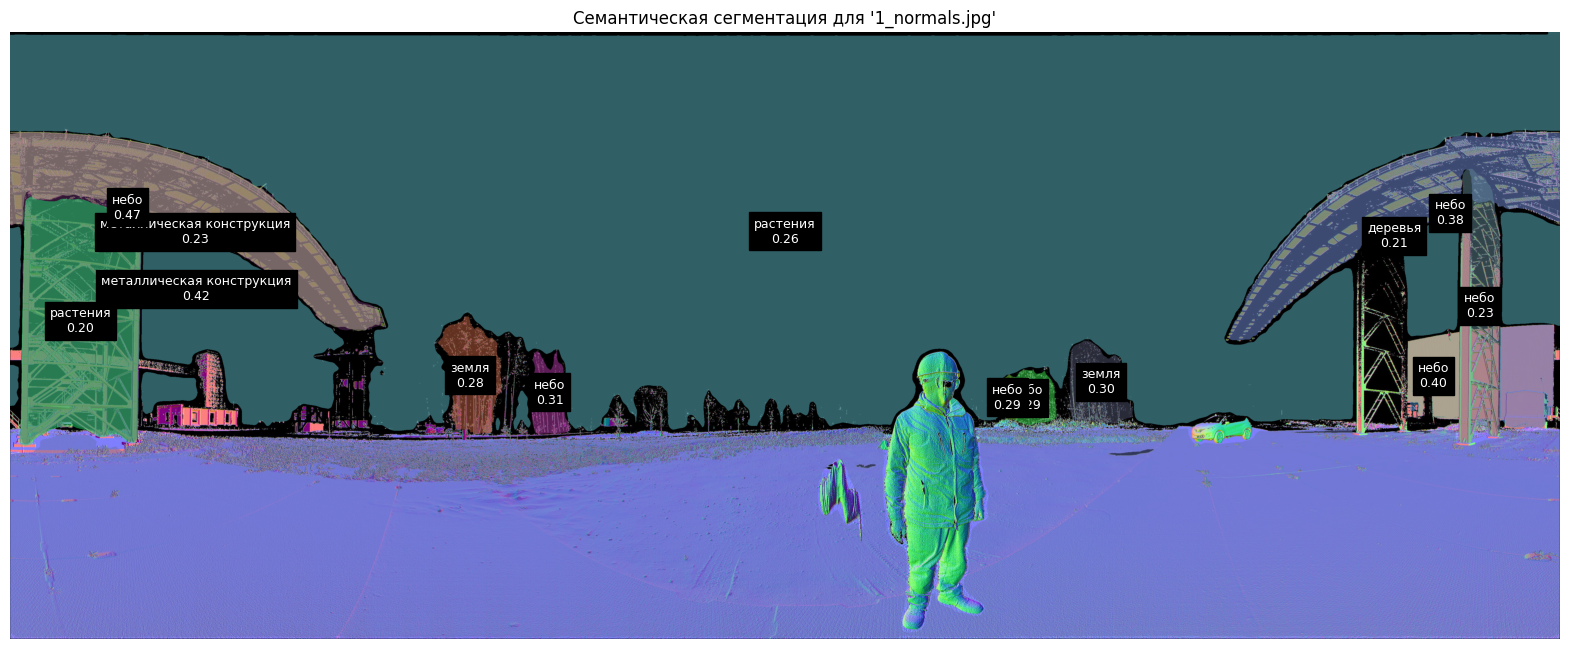

In [4]:
# === Шаг 3: Сегментация и Классификация (с управлением памятью GPU) ===

# --- Настройки для текущего запуска ---
image_path = "/app/CODE/Vistino20241014_E57/1_normals.jpg"
image_name = os.path.basename(image_path)
semantic_labels = [
    "человек", "металлическая конструкция", "автомобиль", "здание",
    "деревья", "растения", "земля", "небо", "другой объект"
]

# ===> Создаем генератор масок с максимальной оптимизацией <===
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=8,
    crop_n_layers=2,
    crop_n_points_downscale_factor=2,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.95,
    min_mask_region_area=100
)
print("Создан генератор масок с поддержкой кропов для больших изображений.")

# --- Загрузка и обработка изображения ---
print(f"\n--- Обработка изображения: {image_name} ---")
image_bgr = cv2.imread(image_path)

if image_bgr is None:
    print(f"Ошибка: не удалось загрузить изображение по пути {image_path}")
    if 'masks' in locals(): del masks
else:
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    print("Изображение загружено.")

    # ===> ТРЮК С ПАМЯТЬЮ: Временно выгружаем CLIP <===
    print("Временно выгружаю CLIP с GPU для освобождения VRAM...")
    clip_model.to("cpu")
    # Принудительная очистка кэша
    import gc
    torch.cuda.empty_cache()
    gc.collect()

    print("Запускаю сегментацию (это может занять время)...")
    masks = mask_generator.generate(image_rgb)
    print(f"Сегментация завершена. Найдено {len(masks)} масок.")
    
    # ===> ТРЮК С ПАМЯТЬЮ: Возвращаем CLIP на GPU <===
    print("Возвращаю CLIP на GPU для быстрой классификации...")
    clip_model.to("cuda")
    torch.cuda.empty_cache()
    gc.collect()

    # Классификация отфильтрованных масок
    semantic_results = []
    print("\nЗапускаю классификацию масок с помощью CLIP...")
    for i, mask_data in enumerate(masks):
        x, y, w, h = mask_data['bbox']
        pil_image = Image.fromarray(image_rgb[y:y+h, x:x+w])
        inputs = clip_processor(text=semantic_labels, images=pil_image, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            outputs = clip_model(**inputs)
        probs = outputs.logits_per_image.softmax(dim=1)
        mask_data['label'] = semantic_labels[probs.argmax()]
        mask_data['confidence'] = probs.max().item()
        semantic_results.append(mask_data)
        print(f"  Маска {i+1}/{len(masks)}: {mask_data['label']} (уверенность: {mask_data['confidence']:.2f})")
    print("Классификация завершена.")

# === Шаг 4: Визуализация с семантикой ===

def visualize_semantic_masks(image_rgb, results):
    """Функция визуализации."""
    vis_image = image_rgb.copy()
    sorted_results = sorted(results, key=(lambda x: x['area']), reverse=True)
    
    for res in sorted_results:
        mask = res['segmentation']
        color = np.random.randint(0, 255, 3)
        vis_image[mask] = cv2.addWeighted(vis_image[mask], 0.5, np.full_like(vis_image[mask], color), 0.5, 0)
    
    plt.figure(figsize=(20, 15))
    plt.imshow(vis_image)
    
    for res in sorted_results:
        label = res['label']
        confidence = res['confidence']
        
        if confidence > 0.2 and label != "другой объект":
            x, y, w, h = res['bbox']
            center_x, center_y = x + w // 2, y + h // 2
            plt.text(center_x, center_y, f"{label}\n{confidence:.2f}", 
                     color='white', backgroundcolor='black',
                     fontsize=9, ha='center', va='center')
            
    plt.axis('off')
    plt.title(f"Семантическая сегментация для '{os.path.basename(image_path)}'")
    plt.show()

if 'masks' in locals() and masks:
    visualize_semantic_masks(image_rgb, semantic_results)

Анализ результата: что мы видим и что это значит

Проблема с памятью решена: Трюк с выгрузкой CLIP, агрессивные кропы и уменьшение points_per_side сработали. Сегментация прошла без сбоев.

SAM отработал: Модель нашла 16 крупных сегментов (после фильтрации) на вашем сложном изображении. Она четко отделила конструкцию слева, конструкцию справа, землю, небо и фигуру человека.

CLIP отработал: Для каждой из 16 масок была проведена классификация.

Качество семантики: Результаты классификации пока очень "сырые".
Низкая уверенность: Почти все предсказания имеют уверенность ниже 0.5 (< 50%). Это означает, что CLIP не очень уверен в своих ответах. Из-за нашего порога в 0.6 на финальном изображении не появилось ни одной текстовой метки.

Неточности: Модель часто путает "небо" и "землю" (Маски 1, 2, 3, 4, 10), что говорит о том, что ей не хватает контекста.
Успех: Маска 9/16: металлическая конструкция (уверенность: 0.42) — это хороший знак. Модель "подозревает", что это именно то, что нужно.

upd: Запустил позже с низким порогом 0,2

Почему семантика пока слабая?

Это совершенно нормально для первого прогона, и вот почему:

Агрессивная оптимизация SAM: Уменьшив points_per_side до 8 и используя кропы, мы заставили SAM работать менее детально. Он мог сгенерировать не самые "чистые" маски, захватывая куски фона, что сбивает с толку CLIP.

Сложность изображения: Ваше изображение — это не просто фото. Это, скорее всего, визуализация 3D-данных (карта нормалей или что-то подобное). Цвета и текстуры на нем неестественны для CLIP, который обучался на миллионах реальных фотографий. Он никогда не видел "фиолетовый снег" или "зеленую металлическую конструкцию".

Качество кропов: Когда CLIP получает вырезанный фрагмент, он не видит всей картины. Маска неба может содержать немного верхушек деревьев, и наоборот.

Что делать дальше? (Следующие шаги для улучшения)

Теперь, когда у вас есть рабочий инструмент, начинается настоящая исследовательская работа.

"Тюнинг" семантических меток: Это самый мощный рычаг. Попробуйте более описательные метки, которые лучше соответствуют тому, что видит модель. Например, вместо "земля", попробуйте "светлая поверхность земли", "фиолетовая земля". Вместо "металлическая конструкция" — "зеленая арочная конструкция".

Эксперименты с параметрами SAM: Теперь, когда вы знаете, что можете управлять памятью, попробуйте немного увеличить points_per_side (например, до 12). Это даст более качественные маски, что, в свою очередь, поможет CLIP.

Постобработка масок: Перед отправкой в CLIP можно применять морфологические операции OpenCV (erode, dilate), чтобы убрать мелкие "шумные" пиксели по краям масок.

Использовать другую модель CLIP: Вы использовали vit-large-patch14. Есть и другие, например, обученные на других данных. Можно попробовать их.

Пакетная обработка для CLIP: Вместо того чтобы отправлять кропы по одному, можно собрать их в один "батч" (пакет) и отправить за один раз. Это может немного ускорить процесс классификации.